# Evaluating the Predictive Capabilities of "Predictive Testing"
## Predicting NCLEX Success for Nursing Students
Author: Alexander Stachniak

# Probability Boundary Score
It is necessary that we develop a numeric score to assist in our analysis of probability boundaries. The "eye test" may prove to be inaccurate, especially as we increase the number of points in our dataset.

Probability Boundary Score is a new metric which rewards both correct decisions made with high probability and incorrect decisions made with low probability. In other words, these are the situations as we want them to occur:
* If the model makes a correct prediction, we want the model to assert that this prediction has a probability as close to 1.00 as possible (near certainty).
* If the model makes an incorrect prediction, we want the model to assert that this prediction has a probability as close to 0.50 as possible (split decision).

We recognize that prediction can never reach 100% accuracy, and therefore our goal with Probability Boundary Score is to provide a metric whereby we can evaluate classifiers in order to choose one which most fully separates predictions by probability scores. 

## A Scenario for Illustration
We might think of this from the perspective of an educator who is presented with the following scenarios:
* Scenario 1: Student A has a 51% chance of passing (no remediation needed); Student B has a 49% chance of passing (remediation needed).
* Scenario 2: Student A has a 90% chance of passing (no remediation needed); Student B has a 10% chance of passing (remediation needed).

In both cases, our cutoff score for remediation is 0.50, but an educator is much more likely to question the usefulness of the predictive model in Scenario 1. Indeed, for the educator, probability will be conflated with confidence.

## What the Scores Mean
The minimum and maximum possible values for Probability Boundary Score are 0.00 and 1.00, respectively, providing a close analog to the possible values of standard probability. A score near 0.00 would indicate that a model was either very inaccurate or entirely unable to gain separation between probabilities. As scores increase towards 1.00, the model becomes more accurate and more likely to assert high probabilities for correct predictions.

Probability Boundary Score was created as a metric specifically for use in a two-class decision case. To include multiple classes, it would need to be used as a one vs. many calculation.

In [26]:
# For display of mathematical formulae
from IPython.display import Math
Math(r'pb_{score} = \frac {\sum \left| P_{correct} - B \right| + \sum \bigl( B - \left| P_{incorrect} - B \right| \bigr)} {n} ')

<IPython.core.display.Math object>

* P_correct: the probability assigned to a prediction that turned out to be correct
* P_incorrect: the probability assigned to a prediction that turned out to be incorrect
* B: the probability boundary (assumed to be 0.50 unless otherwise specified)
* n: the total number of samples

## Probability Boundary Score and Class Imbalance
Note that the equation above could also be modified to produce a Probability Boundary Score that was weighted to account for class imbalance. To do so, we would simply separate the predictions by true class, calculate the Probability Boundary Score for each class, then average the scores together.

The overall effect of weighting the Probability Boundary Score will depend on how likely the model is to predict the minority class. Like any metric, this should be used with caution. In a case where the model is extremely unlikely to predict the minority class, each one of those predictions will have an outsized effect on the overall score.

# Importing Probability Boundary as a Class
The probability_boundary.py library makes use of Numpy and Matplotlib. Although we could import using "%run probability_boundary.py", here we will display the full code for the purpose of review.

In [22]:
# Display plots within Jupyter Notebook
%matplotlib inline

# Caution: use only when certain of results
import warnings
warnings.filterwarnings('ignore')

In [93]:
# %load probability_boundary.py
"""
Probability Boundary Score

@author: zstachniak
"""

# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class probability_boundary:
    '''A class that represents probability scores weighted by true values.'''
    
    def __init__ (self, y_pred_prob, y_true, boundary=0.50):
        '''Function initializes the probability boundary score given 
        a set of prediction probabilities and the true values. Upon 
        initialization, function gathers both an unweighted score and 
        a score that is balanced by class size, in which case the score 
        is calculated separately for each class and then averaged.

        @ Parameters:
        ------------------
            y_pred_prob: array of probability scores for each class
            y_true: array of true class values
            boundary: float value between 0.00 and 1.00
        '''
        # Coerce to ensure values are not imported with unordered indices 
        # (e.g., a shuffled Pandas series)
        self.y_pred_prob = np.asarray(y_pred_prob)
        self.y_true = np.asarray(y_true)
        
        # Preserve boundary value
        self.boundary = boundary
        
        # Unweighted Probability Boundary Score
        # Sample Size
        n = self.y_true.shape[0]
        # Make predictions
        y_pred = np.argmax(self.y_pred_prob, axis=1)
        # Identify correct predictions
        P_correct = self.y_pred_prob[np.argwhere(y_pred == self.y_true)]
        # Identify incorrect predictions
        P_incorrect = self.y_pred_prob[np.argwhere(y_pred != self.y_true)]
        # Caculate Probability Boundary Score
        pb_correct = np.sum(np.absolute(P_correct - boundary))
        pb_incorrect = np.sum(boundary - np.absolute(P_incorrect - boundary))
        self.unweighted = (pb_correct + pb_incorrect) / n
        
        # Weighted Probability Boundary Score
        # Determine class values
        classes = np.unique(self.y_true)
        # Initialize dictionary for storage and code re-use
        pb_dict = {}
        # Iterate through classes
        for c in classes:
            # Separate out classes
            pb_dict[c] = {'y_pred_prob': self.y_pred_prob[np.argwhere(self.y_true == c).flatten()],
                          'y_true': self.y_true[np.where(self.y_true == c)[0]]
                         }
            # Sample size
            pb_dict[c]['n'] = len(pb_dict[c]['y_true'])
            # Make predictions
            pb_dict[c]['y_pred'] = np.argmax(pb_dict[c]['y_pred_prob'], axis=1)
            # Identify correct predictions
            pb_dict[c]['P_correct'] = pb_dict[c]['y_pred_prob'][np.argwhere(pb_dict[c]['y_pred'] == pb_dict[c]['y_true']).flatten()]
            # Identify incorrect predictions
            pb_dict[c]['P_incorrect'] = pb_dict[c]['y_pred_prob'][np.argwhere(pb_dict[c]['y_pred'] != pb_dict[c]['y_true']).flatten()]
            # Calculate Probability Boundary Score
            pb_dict[c]['pb_correct'] = np.sum(np.absolute(pb_dict[c]['P_correct'] - boundary))
            pb_dict[c]['pb_incorrect'] = np.sum(boundary - np.absolute(pb_dict[c]['P_incorrect'] - boundary))
            pb_dict[c]['pb_score'] = (pb_dict[c]['pb_correct'] + pb_dict[c]['pb_incorrect']) / pb_dict[c]['n']
        # Average scores for weighted
        self.weighted = np.mean([pb_dict[c]['pb_score'] for c in classes])

    def __repr__ (self):
        'Canonical representation'
        return 'probability_boundary({0}, {1}, {2})'.format(self.y_pred_prob, self.y_true, self.boundary)
        
    def __str__ (self):
        'String representation'
        return 'Unweighted: {0:.2f} | Weighted {1:.2f}'.format(self.unweighted, self.weighted)
            
    def weighted_score (self):
        'Return the weighted score'
        return self.weighted
    
    def unweighted_score (self):
        'Return the unweighted score'
        return self.unweighted
            
    def plot (self, width=14, height=5, subplot=111):
        '''A function that displays a plot of probability boundaries.
        
        @ Parameters:
        ------------------
            width: width of plot in inches
            height: height of plot in inches
            subplot: three-digit shorthand for subplot
        '''
        
        # Set default plot size
        plt.rcParams['figure.figsize'] = (width, height)

        # Number of samples
        n = self.y_pred_prob.shape[0]
        # x value is the index of array
        x = np.arange(n)
        # y value is the probability of the element being class 1
        y = self.y_pred_prob[:,1]
        # Red indicates 0 (Fail) and blue indicates 1 (Pass)
        colors = ['red', 'blue']

        # Plot probability boundaries
        f = plt.figure()
        sp = f.add_subplot(subplot)
        sp.set_ylim([-0.05, 1.05])
        sp.scatter(x, y, c=self.y_true, cmap=ListedColormap(colors), alpha=0.6)
        sp.axhline(y=self.boundary, color='r', linestyle='--')
        sp.set_title('Probability Boundary (Color = True Class)\nUnweighted: {0:.2f} | Weighted: {1:.2f}'.format(self.unweighted, self.weighted))
        sp.set_xlabel('Observation')
        sp.set_ylabel('Class Probability Assigned by Model')
        return f

## Loading the Data

In [36]:
import pickle
with open('df_dict.pickle', 'rb') as file:
    df_dict = pickle.load(file)

## Demonstrating Use

In [80]:
test = probability_boundary(df_dict[7]['log_pred_prob'], df_dict[7]['y_test'])

In [81]:
print(test)

Unweighted: 0.63 | Weighted 0.59


In [82]:
test.unweighted

0.63038683610454294

In [83]:
test.weighted

0.58957740647362067

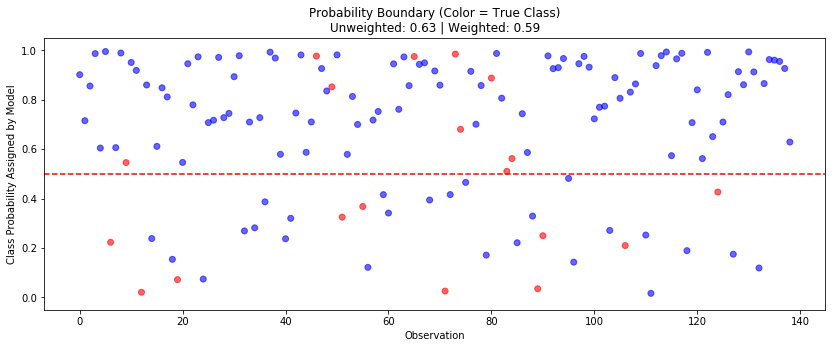

In [89]:
p = test.plot()

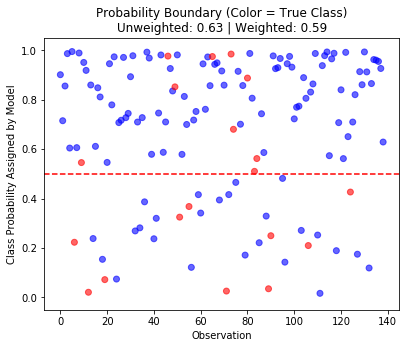

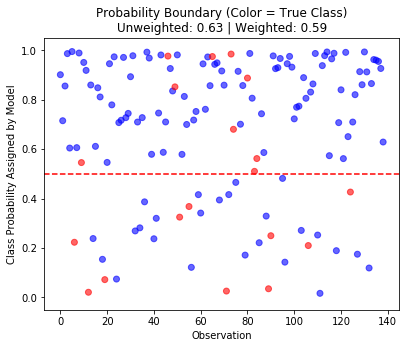

In [95]:
test.plot(subplot=121)